In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

### Adapting N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

### Utilities

In [8]:
function load_Ts(folder)
    ell_vector = sort!(npzread("ell_vector.npy")) 
    full_T = zeros(26, 100, 100, 129)
    for i in 1:26
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        if isfile(filename)
            full_T[i,:,:,:] = npzread(filename)
        else
            full_T[i,:,:,:] = zeros(100,100,129)
        end
    end
    return full_T
end

load_Ts (generic function with 1 method)

In [9]:
function plot_pmd(w, i, label,ell_list="ell_vector.npy")
    ell_vector = npzread("ell_vector.npy")
    ℓ = round(ell_vector[i], digits=1)
    p = heatmap(log10.(abs.(w[i,:,:]./maximum(w[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ), $label")
    return plot(p, layout=(1,1))
end;

In [10]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
nχ = 100
χ = LinRange(26, 7000, nχ)
ℓ = sort!(npzread("ell_vector.npy"))

k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

In [11]:
T_LL = load_Ts("working_Ts/T_tilde_LL")
T_CL = load_Ts("working_Ts/T_tilde_CL")
T_CC = load_Ts("working_Ts/T_tilde_CC")

w_LL = Will.w_ell_tullio(coeff, T_LL)
w_CL = Will.w_ell_tullio(coeff, T_CL)
w_CC = Will.w_ell_tullio(coeff, T_CC);

#### a couple plots for safety

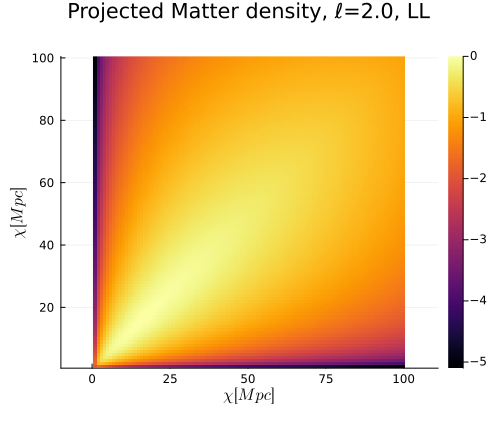

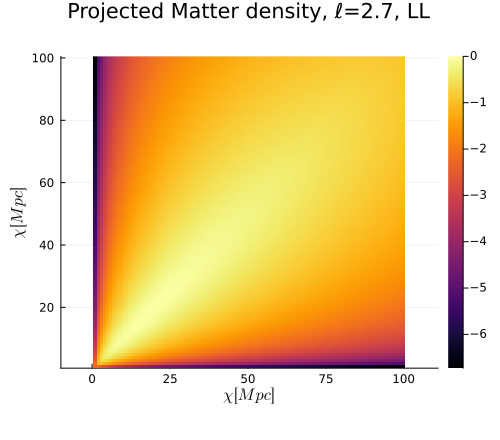

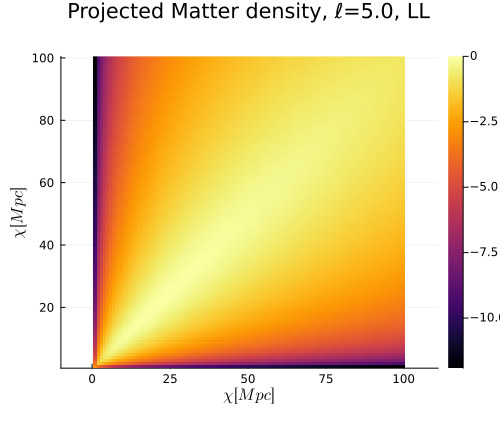

In [12]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_LL, i, "LL"))
end

for plot in plots
    display(plot)
end

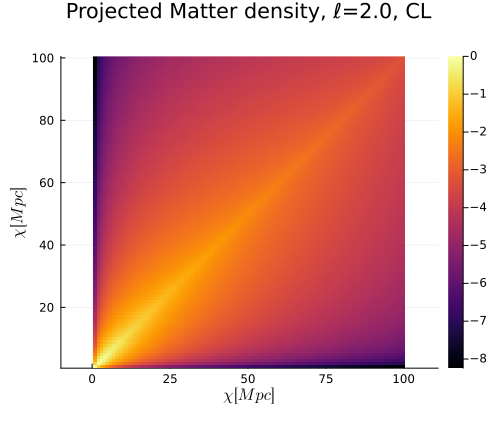

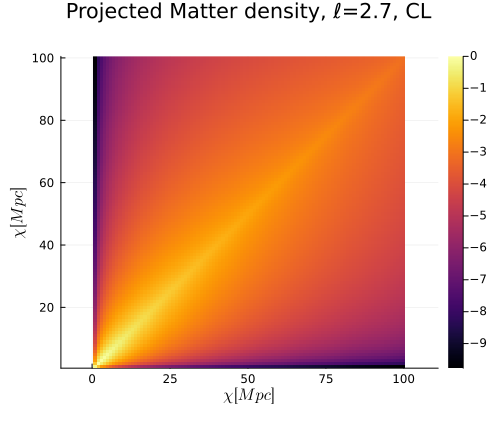

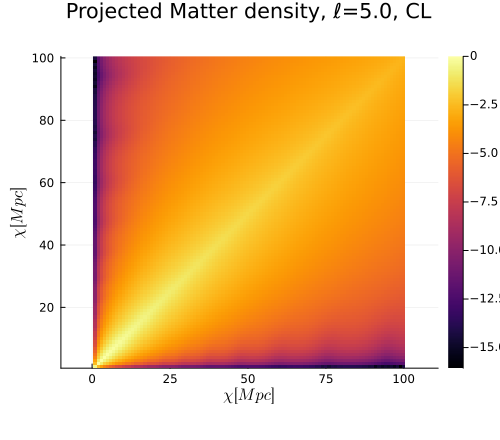

In [13]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_CL, i, "CL"))
end

for plot in plots
    display(plot)
end

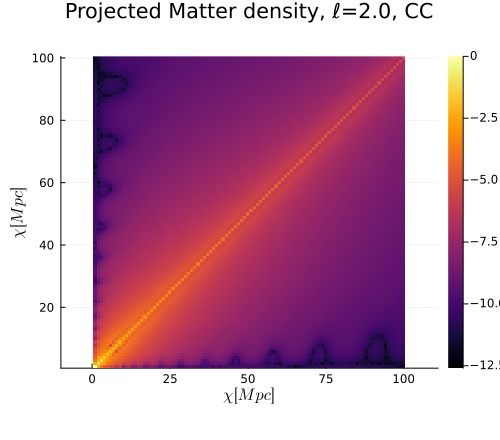

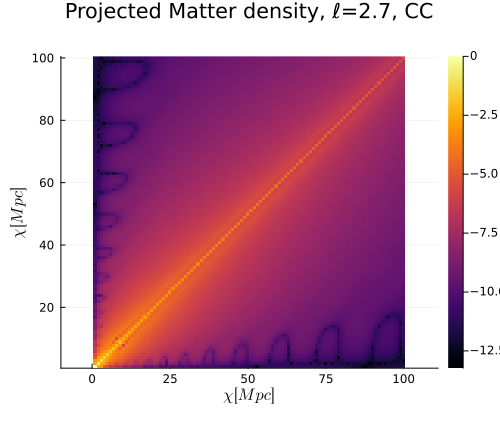

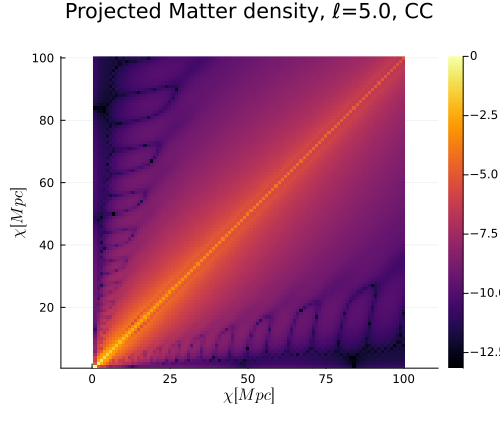

In [14]:
plots = []
for i in 1:3
    push!(plots, plot_pmd(w_CC, i, "CC"))
end

for plot in plots
    display(plot)
end

# $C_{\ell}$'s computation

In [15]:
W

LoadError: UndefVarError: `W` not defined

In [16]:
#Import window functions
W = npzread("../N5K/input/kernels_fullwidth.npz")
WA = W["kernels_sh"]
WB = W["kernels_cl"]
WA_interp = zeros(5,nχ)
WB_interp = zeros(10,nχ)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp[i,:] = interp.(χ)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp[i,:] = interp.(χ)
end;

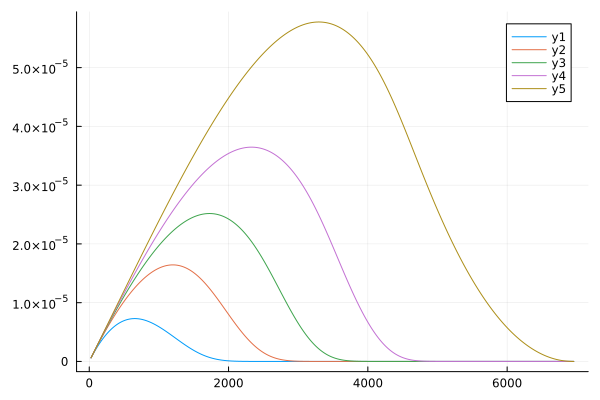

In [17]:
p = plot()
for i in 1:5
    plot!(p, W["chi_cl"], WA[i,:])
end
p

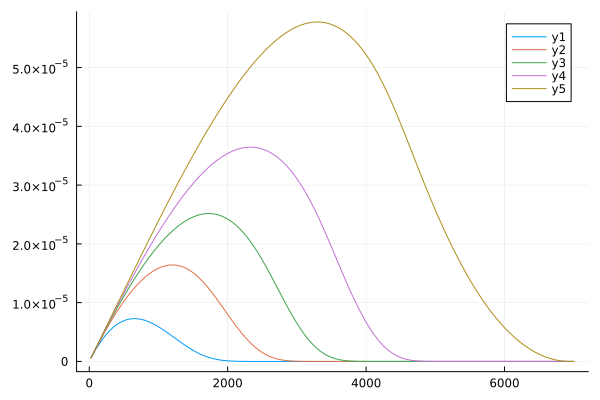

In [18]:
p = plot()
for i in 1:5
    plot!(p, χ, WA_interp[i,:])
end
p

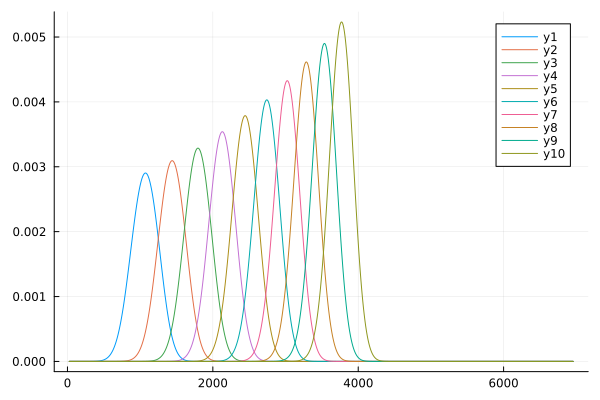

In [19]:
p = plot()
for i in 1:10
    plot!(p, W["chi_cl"], WB[i,:])
end
p

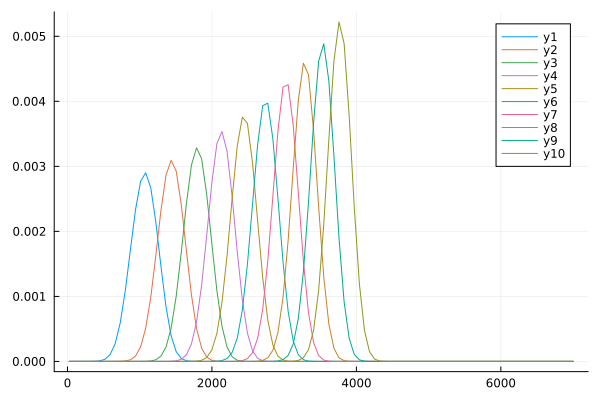

In [20]:
p = plot()
for i in 1:10
    plot!(p, χ, WB_interp[i,:])
end
p

In [21]:
# ADDING CHI FACTORS TO LENSING WINDOW FUNCTIONS
WA_LL = zeros(5,nχ)
for i in 1:size(WA_interp)[1]
    WA_LL[i,:] = WA_interp[i,:] ./ (Array(χ) .^ 2)
end;

In [22]:
function C_ell_computation_trap(w, WA, WB)
    pesi = ones(100)
    pesi[1] = 0.5
    pesi[100] = 0.5
    @tullio int1[i,m,j] := ((χ[100]-χ[1])/99)*( w[i,l,m]*WA[j,l]*pesi[l] )
    @tullio Cℓ[i,j,k] := ((χ[100]-χ[1])/99)*(int1[i,m,j]*WB[k,m]*pesi[m])
end;

In [23]:
Cℓ_CC2 = C_ell_computation_trap(w_CC, WB_interp, WB_interp);
Cℓ_LL2 = C_ell_computation_trap(w_LL, WA_LL, WA_LL)
Cℓ_CL2 = C_ell_computation_trap(w_CL, WA_LL, WB_interp);

In [24]:
function SimpsonWeightArray(n)
    number_intervals = floor((n-1)/2)
    weight_array = zeros(n)
    if n == number_intervals*2+1
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
    else
        weight_array[1] += 0.5
        weight_array[2] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)+1] += 1/3
            weight_array[Int((i-1)*2+2)+1] += 4/3
            weight_array[Int((i-1)*2+3)+1] += 1/3
        end
        weight_array[length(weight_array)]   += 0.5
        weight_array[length(weight_array)-1] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
        weight_array ./= 2
    end
    return weight_array
end;

In [25]:
function C_ell_computation_simpson(w, WA, WB)
    pesi = SimpsonWeightArray(length(w[1,1,:]))
    @tullio int1[i,m,j] := ((χ[100]-χ[1])/99)*w[i,l,m]*WA[j,l]*pesi[l] 
    @tullio Cℓ[i,j,k] := ((χ[100]-χ[1])/99)*int1[i,m,j]*WB[k,m]*pesi[m]
end;

In [26]:
Cℓ_CC = C_ell_computation_simpson(w_CC, WB_interp, WB_interp);
Cℓ_LL = C_ell_computation_simpson(w_LL, WA_LL, WA_LL)
Cℓ_CL = C_ell_computation_simpson(w_CL, WA_LL, WB_interp);

In [27]:
# ADDING ELL PREFACTORS
Cℓ_CC = Cℓ_CC .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = sort!(npzread("ell_vector.npy"))
for i in 1:length(ell_vector)
    Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

In [28]:
# ADDING ELL PREFACTORS
Cℓ_CC2 = Cℓ_CC2 .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = sort!(npzread("ell_vector.npy"))
for i in 1:length(ell_vector)
    Cℓ_LL2[i,:,:] = Cℓ_LL2[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL2[i,:,:] = Cℓ_CL2[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

#### Loading N5K stuff

In [29]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [30]:
gg = benchmark_gg["cls"]
ll = benchmark_ll["cls"]
gl = benchmark_gl["cls"]
ell = benchmark_gg["ls"];

In [31]:
gg_reshaped = zeros(length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [32]:
ll_reshaped = zeros(length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [33]:
gl_reshaped = zeros(length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in i:5
        gl_reshaped[:,i,j] = gl[counter, :]
        gl_reshaped[:,j,i] = gl_reshaped[:,i,j]
        counter += 1
    end
end

## Let's take a loook

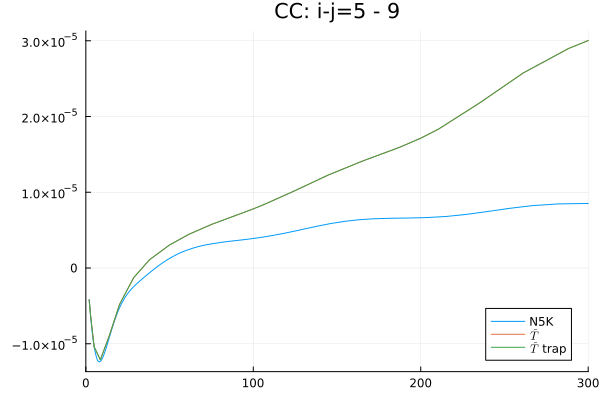

In [55]:
i = 5
j = 9
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$")
plot!(ℓ, Cℓ_CC2[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ trap", legend=:bottomright)

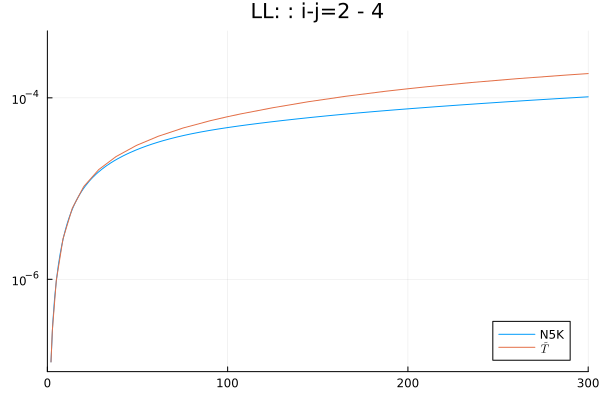

In [50]:
i = 2
j = 4
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$",legend=:bottomright)

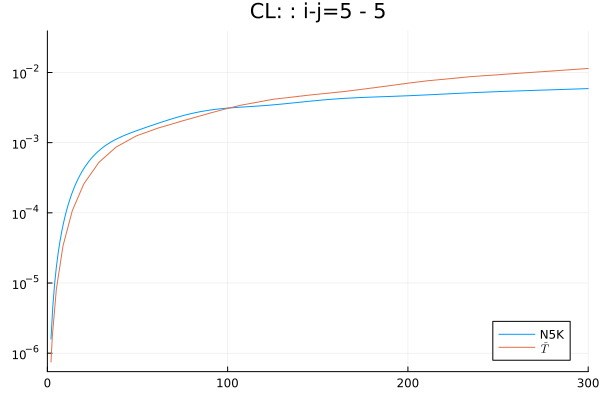

In [53]:
i = 5
j = 5
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300),yscale=:log10)
plot!(ℓ, Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$", legend=:bottomright)